In [1]:
#!pip install syft

In [2]:
import syft as sy
from syft.core.node.new.util import autocache, PANDAS_DATA
sy.requires(">=0.8-beta")

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/koen/workspace/PySyft


✅ The installed version of syft==0.8.0b6 matches the requirement >=0.8b0


# Data owner: upload data

In [3]:
node = sy.orchestra.launch(name="test-domain-1", reset=True)

SQLite Store Path:
!open file:///var/folders/q1/ryq93kwj055dlbpngxv1c7z40000gn/T/7bca415d13ed1ec841f0d0aede098dbb.sqlite

> Starting Worker: test-domain-1 - 7bca415d13ed1ec841f0d0aede098dbb - NodeType.DOMAIN - [<class 'syft.core.node.new.user_service.UserService'>, <class 'syft.core.node.new.metadata_service.MetadataService'>, <class 'syft.core.node.new.action_service.ActionService'>, <class 'syft.core.node.new.test_service.TestService'>, <class 'syft.core.node.new.dataset_service.DatasetService'>, <class 'syft.core.node.new.user_code_service.UserCodeService'>, <class 'syft.core.node.new.request_service.RequestService'>, <class 'syft.core.node.new.data_subject_service.DataSubjectService'>, <class 'syft.core.node.new.network_service.NetworkService'>, <class 'syft.core.node.new.policy_service.PolicyService'>, <class 'syft.core.node.new.message_service.MessageService'>, <class 'syft.core.node.new.project_service.ProjectService'>, <class 'syft.core.node.new.data_subject_member_service.Data

In [4]:
domain_client = node.login(email="info@openmined.org", password="changethis")

In [5]:
# The usual preamble
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (15, 5)

## Load data

We're going to use a new dataset here, to demonstrate how to deal with larger datasets. This is a subset of the of 311 service requests from NYC Open Data.

In [6]:
# because of mixed types we specify dtype to prevent any errors
complaints = pd.read_csv(autocache(f"{PANDAS_DATA}/311-service-requests.csv"), dtype='unicode')

Depending on your pandas version, you might see an error like "DtypeWarning: Columns (8) have mixed types". This means that it's encountered a problem reading in our data. In this case it almost certainly means that it has columns where some of the entries are strings and some are integers.

For now we're going to ignore it and hope we don't run into a problem, but in the long run we'd need to investigate this warning.

In [7]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,26589651,10/31/2013 02:08:41 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11432,90-03 169 STREET,169 STREET,90 AVENUE,91 AVENUE,NaN,NaN,ADDRESS,JAMAICA,NaN,Precinct,Assigned,10/31/2013 10:08:41 AM,10/31/2013 02:35:17 AM,12 QUEENS,QUEENS,1042027,197389,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.70827532593202,-73.79160395779721,"(40.70827532593202, -73.79160395779721)"
1,26593698,10/31/2013 02:01:04 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,11378,58 AVENUE,58 AVENUE,58 PLACE,59 STREET,NaN,NaN,BLOCKFACE,MASPETH,NaN,Precinct,Open,10/31/2013 10:01:04 AM,NaN,05 QUEENS,QUEENS,1009349,201984,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721040535628305,-73.90945306791765,"(40.721040535628305, -73.90945306791765)"
2,26594139,10/31/2013 02:00:24 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10032,4060 BROADWAY,BROADWAY,WEST 171 STREET,WEST 172 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,10/31/2013 10:00:24 AM,10/31/2013 02:39:42 AM,12 MANHATTAN,MANHATTAN,1001088,246531,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.84332975466513,-73.93914371913482,"(40.84332975466513, -73.93914371913482)"
3,26595721,10/31/2013 01:56:23 AM,10/31/2013 02:21:48 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10023,WEST 72 STREET,WEST 72 STREET,COLUMBUS AVENUE,AMSTERDAM AVENUE,NaN,NaN,BLOCKFACE,NEW YORK,NaN,Precinct,Closed,10/31/2013 09:56:23 AM,10/31/2013 02:21:10 AM,07 MANHATTAN,MANHATTAN,989730,222727,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.7780087446372,-73.98021349023975,"(40.7780087446372, -73.98021349023975)"
4,26590930,10/31/2013 01:53:44 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,Vacant Lot,10027,WEST 124 STREET,WEST 124 STREET,LENOX AVENUE,ADAM CLAYTON POWELL JR BOULEVARD,NaN,NaN,BLOCKFACE,NEW YORK,NaN,NaN,Pending,11/30/2013 01:53:44 AM,10/31/2013 01:59:54 AM,10 MANHATTAN,MANHATTAN,998815,233545,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.80769092704951,-73.94738703491433,"(40.80769092704951, -73.94738703491433)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111064,26426013,10/04/2013 12:01:13 AM,10/07/2013 04:07:16 PM,DPR,Department of Parks and Recreation,Maintenance or

## Create Mock data

In [8]:
from syft.core.node.new.mock import CachedFaker
from random import randint
import random

Let's create the mock data for the complaint dataset.

In [9]:
fake = CachedFaker()

In [10]:
fake_functions = {
    "Unique Key": lambda x: randint(1,1000000),
    "Location": lambda x: (fake.coordinate(), fake.coordinate()),
    "Agency": lambda x: random.choice(["NYPD", "DOHMH", "DPR"]),
    "X Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Y Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Complaint Type": lambda x: random.choice(["Illegal Parking", "Noise - Street/Sidewalk", "'Animal in a Park'"]),
    "Descriptor": lambda x: random.choice([ 'Branch or Limb Has Fallen Down','Branches Damaged','Broken Fence', 'Broken Glass']),
    "School Number": lambda x: random.choice([ 'B073', 'B077', 'B079', 'B080-01', 'B087', 'B099', 'B100', 'B102', 'B109', 'B111']),
    "Bridge Highway Segment": lambda x: random.choice([ 'Grand Central Pkwy (Exit 1 E-W)',
                                                       'Grand Central Pkwy (Exit 10) - 69th Rd-Jewel Ave (Exit 11)',
                                                       'GrandCentral Pkwy/VanWyck Expwy/College Point Blvd (Exit 22 A-E)',
                                                       'Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278) (Exit 1)',
                                                       'Harding Ave (Exit 9) - Throgs Neck Br'])
}

In [11]:
fake_triggers = {
    "Street": lambda x : fake.street_name(),
    "Date": lambda x : fake.date_time(),
    "Long": lambda x : fake.coordinate(),
    "Lat": lambda x : fake.coordinate(),
    "Address": lambda x : fake.address(),
    "Name": lambda x : fake.name(),
    "City": lambda x : fake.city(),
    "Zip": lambda x : fake.zipcode(),
}

In [12]:
mock_data = dict()
for col in complaints.columns:
    col_vals = complaints[col]
    
    if col in fake_functions:
        mock_func = fake_functions[col]
    elif len(set(complaints[col])) < 100:
        values = list(set(complaints[col]))
        mock_func = lambda x: random.choice(values)
    else:
        for trigger in fake_triggers.keys():
            if trigger in col:
                mock_func = fake_triggers[trigger]
    mock_data[col] = [mock_func(None) for x in range(len(complaints))]

In [13]:
mock = pd.DataFrame(data=mock_data)

In [14]:
mock.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,893238,2014-08-17 21:17:54,1977-05-11 23:37:13,DOHMH,Michelle Green,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Crosswalk,86429,"PSC 7001, Box 9105\nAPO AA 17697",Patricia Brown,Mark Land,Sabrina Inlet,Debra Valleys,Kimberly Lane,PLACENAME,North Susanton,MADISON SQUARE GARDEN,DSNY Garage,Unassigned,1987-11-02 08:13:13,1989-05-28 08:48:13,03 BROOKLYN,BRONX,247894,919807,Alicia Anderson,Unspecified,John Brandt,B102,Region 1,12X217,7182354100,"5338 Cheryl Mount Suite 708\nHeatherbury, WY 2...",QUEENS,Unspecified,88270,NaN,NaN,Ambulette / Paratransit,NaN,NaN,FDR Dr,NaN,NaN,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Bayside Field,NaN,HOWARD BEACH SENIOR CENTER,158.353743,-84.172346,"(85.321319, 125.954564)"
1,911146,1984-12-12 23:51:08,1987-09-04 14:36:04,DOHMH,Karen Ruiz,'Animal in a Park',Broken Glass,Street/Sidewalk,87224,"2293 Day Lane\nLake Stanley, VA 61703",Jacqueline Howard,Myers Landing,Lisa Meadows,Nguyen Cliff,Jessica Valley,BLOCKFACE,Fitzpatricktown,BKLYN BATTERY TUNNEL,School,Closed,2005-04-17 20:30:35,2011-07-29 17:21:34,07 MANHATTAN,MANHATTAN,717302,262078,Patricia Brown,BROOKLYN,Eric Smith,B100,Region 9,16K335,7184301800,"7555 Melinda Well\nPaynemouth, AK 42256",BROOKLYN,Unspecified,12647,N,NaN,NaN,STATEN ISLAND,New York-Penn Station,Whitestone Expwy,South/Downtown,Roadway,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Flushing #2 Field,NaN,JUNE AGARRATT,-89.679221,85.321319,"(173.712459, 125.954564)"
2,465363,1987-04-18 00:16:06,2012-01-10 05:09:32,DPR,Donna Fitzpatrick,'Animal in a Park',Broken Glass,Bus Stop Shelter,24767,"26763 Edwards Fork Apt. 491\nMorrisport, ID 04066",Amber Aguilar,Guerrero Inlet,Jessica Valley,Jason Underpass,Allen Cove,PLACENAME,Timothyberg,UNION SQUARE PARK,Precinct,Started,1999-07-21 09:42:11,1991-02-11 02:10:27,11 BROOKLYN,BRONX,869744,666033,Jeffrey Mccormick,QUEENS,Alexander Collier,B111,Region 9,08X405,6463958083,"860 Wilcox Walk\nWest Tiffanyfort, OR 94995",ROCKAWAY PARK,Unspecified,22919,N,NaN,NaN,BRONX,Grand Central Station,Westchester Ave Br - Bronx River,South/Queens Bound,NaN,Harding Ave (Exit 9) - Throgs Neck Br,Far Rockaway #2 Field,Manhattan Bound,IRA WEINSTEIN,172.789677,81.524937,"(-120.713582, 171.823512)"
3,438896,1971-08-14 10:06:15,2016-11-25 00:00:52,NYPD,Christopher Ward,Noise - Street/Sidewalk,Branches Damaged,Residential,87816,"1744 Madden Fort\nNorth Richard, KS 34257",Christian Roy,Max Ville,Shannon Harbors,Rodriguez Square,Kimberly Landing,INTERSECTION,Amandahaven,INWOOD HILL PARK,NaN,Started,2002-12-20 18:01:45,2017-11-07 21:34:13,08 MANHATTAN,MANHATTAN,766427,47740,Brenda Olson,MANHATTAN,Gabriel Osborne,B087,Region 8,31R440,7188605544,"817 Tate Village Suite 581\nPort Emilyton, PR ...",GLEN OAKS,NY,55155,Y,NaN,Commuter Van,QUEENS,Intersection,Jackie Robinson/Interboro Pkwy,South/Toward Triborough Br,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Flushing #3 Field,Staten Island Bound,Whitehall Terminal (Manhattan),-136.264546,98.456802,"(102.453845, -65.214550)"
4,829610,2018-07-06 14:19:27,2020-03-11 00:29:56,DOHMH,Michael Smith Jr.,Illegal Parking,Broken Fence,Bus Stop Shelter,35725,"204 Lee Route\nNorth Meaganmouth, MS 68337",Edward Jennings,William 

In [15]:
dataset = sy.Dataset(name="test",
                     asset_list=[sy.Asset(name="complaints", data=complaints, mock=mock, mock_is_real=False)])
domain_client.upload_dataset(dataset)


  0%|                                                                                                                 | 0/1 [00:00<?, ?it/s]

Uploading: complaints


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.05s/it]


<class 'syft.core.node.new.response.SyftSuccess'>: Dataset Added

## Create data scientist

In [ ]:
user = domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data scientist: Create syft_function

## Download mock and submit project

### Get mock

In [18]:
guest_domain_client = node.client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [19]:
ds = guest_domain_client.datasets[0]

In [20]:
asset = ds.assets["complaints"]

In [22]:
complaints = asset.mock

### Selecting only noise complaints


I'd like to know which borough has the most noise complaints. First, we'll take a look at the data to see what it looks like:

In [23]:
complaints[:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,893238,2014-08-17 21:17:54,1977-05-11 23:37:13,DOHMH,Michelle Green,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Crosswalk,86429,"PSC 7001, Box 9105\nAPO AA 17697",Patricia Brown,Mark Land,Sabrina Inlet,Debra Valleys,Kimberly Lane,PLACENAME,North Susanton,MADISON SQUARE GARDEN,DSNY Garage,Unassigned,1987-11-02 08:13:13,1989-05-28 08:48:13,03 BROOKLYN,BRONX,247894,919807,Alicia Anderson,Unspecified,John Brandt,B102,Region 1,12X217,7182354100,"5338 Cheryl Mount Suite 708\nHeatherbury, WY 2...",QUEENS,Unspecified,88270,None,NaN,Ambulette / Paratransit,None,None,FDR Dr,None,None,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Bayside Field,None,HOWARD BEACH SENIOR CENTER,158.353743,-84.172346,"[85.321319, 125.954564]"
1,911146,1984-12-12 23:51:08,1987-09-04 14:36:04,DOHMH,Karen Ruiz,'Animal in a Park',Broken Glass,Street/Sidewalk,87224,"2293 Day Lane\nLake Stanley, VA 61703",Jacqueline Howard,Myers Landing,Lisa Meadows,Nguyen Cliff,Jessica Valley,BLOCKFACE,Fitzpatricktown,BKLYN BATTERY TUNNEL,School,Closed,2005-04-17 20:30:35,2011-07-29 17:21:34,07 MANHATTAN,MANHATTAN,717302,262078,Patricia Brown,BROOKLYN,Eric Smith,B100,Region 9,16K335,7184301800,"7555 Melinda Well\nPaynemouth, AK 42256",BROOKLYN,Unspecified,12647,N,NaN,None,STATEN ISLAND,New York-Penn Station,Whitestone Expwy,South/Downtown,Roadway,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Flushing #2 Field,None,JUNE AGARRATT,-89.679221,85.321319,"[173.712459, 125.954564]"
2,465363,1987-04-18 00:16:06,2012-01-10 05:09:32,DPR,Donna Fitzpatrick,'Animal in a Park',Broken Glass,Bus Stop Shelter,24767,"26763 Edwards Fork Apt. 491\nMorrisport, ID 04066",Amber Aguilar,Guerrero Inlet,Jessica Valley,Jason Underpass,Allen Cove,PLACENAME,Timothyberg,UNION SQUARE PARK,Precinct,Started,1999-07-21 09:42:11,1991-02-11 02:10:27,11 BROOKLYN,BRONX,869744,666033,Jeffrey Mccormick,QUEENS,Alexander Collier,B111,Region 9,08X405,6463958083,"860 Wilcox Walk\nWest Tiffanyfort, OR 94995",ROCKAWAY PARK,Unspecified,22919,N,NaN,None,BRONX,Grand Central Station,Westchester Ave Br - Bronx River,South/Queens Bound,None,Harding Ave (Exit 9) - Throgs Neck Br,Far Rockaway #2 Field,Manhattan Bound,IRA WEINSTEIN,172.789677,81.524937,"[-120.713582, 171.823512]"
3,438896,1971-08-14 10:06:15,2016-11-25 00:00:52,NYPD,Christopher Ward,Noise - Street/Sidewalk,Branches Damaged,Residential,87816,"1744 Madden Fort\nNorth Richard, KS 34257",Christian Roy,Max Ville,Shannon Harbors,Rodriguez Square,Kimberly Landing,INTERSECTION,Amandahaven,INWOOD HILL PARK,None,Started,2002-12-20 18:01:45,2017-11-07 21:34:13,08 MANHATTAN,MANHATTAN,766427,47740,Brenda Olson,MANHATTAN,Gabriel Osborne,B087,Region 8,31R440,7188605544,"817 Tate Village Suite 581\nPort Emilyton, PR ...",GLEN OAKS,NY,55155,Y,NaN,Commuter Van,QUEENS,Intersection,Jackie Robinson/Interboro Pkwy,South/Toward Triborough Br,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Flushing #3 Field,Staten Island Bound,Whitehall Terminal (Manhattan),-136.264546,98.456802,"[102.453845, -65.214550]"
4,829610,2018-07-06 14:19:27,2020-03-11 00:29:56,DOHMH,Michael Smith Jr.,Illegal Parking,Broken Fence,Bus Stop Shelter,35725,"204 Lee Route\nNorth Meaganmouth, MS 68337",Edward Jennin

To get the noise complaints, we need to find the rows where the "Complaint Type" column is "Noise - Street/Sidewalk". I'll show you how to do that, and then explain what's going on.



In [24]:
noise_complaints = complaints[complaints['Complaint Type'] == "Noise - Street/Sidewalk"]
noise_complaints[:3]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,893238,2014-08-17 21:17:54,1977-05-11 23:37:13,DOHMH,Michelle Green,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Crosswalk,86429,"PSC 7001, Box 9105\nAPO AA 17697",Patricia Brown,Mark Land,Sabrina Inlet,Debra Valleys,Kimberly Lane,PLACENAME,North Susanton,MADISON SQUARE GARDEN,DSNY Garage,Unassigned,1987-11-02 08:13:13,1989-05-28 08:48:13,03 BROOKLYN,BRONX,247894,919807,Alicia Anderson,Unspecified,John Brandt,B102,Region 1,12X217,7182354100,"5338 Cheryl Mount Suite 708\nHeatherbury, WY 2...",QUEENS,Unspecified,88270,None,NaN,Ambulette / Paratransit,None,None,FDR Dr,None,None,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Bayside Field,None,HOWARD BEACH SENIOR CENTER,158.353743,-84.172346,"[85.321319, 125.954564]"
3,438896,1971-08-14 10:06:15,2016-11-25 00:00:52,NYPD,Christopher Ward,Noise - Street/Sidewalk,Branches Damaged,Residential,87816,"1744 Madden Fort\nNorth Richard, KS 34257",Christian Roy,Max Ville,Shannon Harbors,Rodriguez Square,Kimberly Landing,INTERSECTION,Amandahaven,INWOOD HILL PARK,None,Started,2002-12-20 18:01:45,2017-11-07 21:34:13,08 MANHATTAN,MANHATTAN,766427,47740,Brenda Olson,MANHATTAN,Gabriel Osborne,B087,Region 8,31R440,7188605544,"817 Tate Village Suite 581\nPort Emilyton, PR ...",GLEN OAKS,NY,55155,Y,NaN,Commuter Van,QUEENS,Intersection,Jackie Robinson/Interboro Pkwy,South/Toward Triborough Br,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Flushing #3 Field,Staten Island Bound,Whitehall Terminal (Manhattan),-136.264546,98.456802,"[102.453845, -65.214550]"
13,954719,1997-10-02 01:12:25,1990-06-08 16:55:07,NYPD,Kevin Torres,Noise - Street/Sidewalk,Broken Fence,Address Outside of NYC,12647,"9220 Ethan Street Suite 403\nSouth Amber, WA 1...",Eric Elliott Jr.,Mcdowell Corners,Thompson Flat,Kenneth Roads,Hubbard Trafficway,LATLONG,Santosbury,CENTRAL PARK,Precinct,Open,1996-11-15 22:41:06,1980-05-19 02:55:25,01 QUEENS,QUEENS,44723,166495,Heather Aguirre,STATEN ISLAND,David Anderson,B111,Region 4,31R011,7188224282,"1616 Jessica Vista Suite 335\nEast Justinbury,...",WOODSIDE,Unspecified,19002,Y,NaN,Ambulette / Paratransit,QUEENS,Intersection,Bronx River Pkwy,South/Long Island Bound,Roadway,Grand Central Pkwy (Exit 1 E-W),St. George Field,Manhattan Bound,PROJECT FIND WOODSTOCK SENIOR CENTER,153.761160,28.957557,"[103.080937, -39.722941]"


If you look at noise_complaints, you'll see that this worked, and it only contains complaints with the right complaint type. But how does this work? Let's deconstruct it into two pieces

In [25]:
complaints['Complaint Type'] == "Noise - Street/Sidewalk"

0          True
1         False
2         False
3          True
4         False
          ...  
111064     True
111065    False
111066    False
111067     True
111068    False
Name: Complaint Type, Length: 111069, dtype: bool

This is a big array of Trues and Falses, one for each row in our dataframe. When we index our dataframe with this array, we get just the rows where our boolean array evaluated to True. It's important to note that for row filtering by a boolean array the length of our dataframe's index must be the same length as the boolean array used for filtering.

You can also combine more than one condition with the & operator like this:

In [26]:
is_noise = (complaints['Complaint Type'] == "Noise - Street/Sidewalk")
in_brooklyn = complaints['Borough'] == "BROOKLYN"
complaints[is_noise & in_brooklyn][:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
29,233447,1976-01-18 04:36:29,1987-08-26 07:01:13,DOHMH,Fred Humphrey,Noise - Street/Sidewalk,Branches Damaged,Roadway Tunnel,04857,"549 Miller Port Suite 505\nEllenborough, WV 86810",Ronald Young,Jones Motorway,Myers Landing,Hall Ways,Jessica Valley,PLACENAME,Sweeneymouth,BARTEL PRITCHARD SQUARE,Precinct,Assigned,1999-10-03 01:13:07,1987-04-18 00:16:06,01 BROOKLYN,BROOKLYN,167754,952435,Kevin Woods,BRONX,Amy Herrera,B077,Region 10,06M143,7183184000,"20961 Thompson Ways Suite 964\nDavidburgh, NJ ...",BROOKLYN,NY,05121,Y,NaN,Ambulette / Paratransit,MANHATTAN,Grand Central Station,Cross Island Pkwy,Eastbound,Roadway,Harding Ave (Exit 9) - Throgs Neck Br,Ditmars #1 and #2 Field,Manhattan Bound,LEGAL SERVICES,-120.713582,-29.787057,"[81.524937, -136.264546]"
32,957578,1996-11-15 22:41:06,2009-10-26 01:18:23,DPR,Christine Murphy,Noise - Street/Sidewalk,Branches Damaged,Address Unknown,59055,"1616 Jessica Vista Suite 335\nEast Justinbury,...",Jacob Mathis,Kimberly Lane,Santos Gardens,Gibson Road,Sabrina Inlet,INTERSECTION,Atkinsonville,BETH ISRAEL MED CENTER,DSNY Garage,Started,2017-11-07 21:34:13,2009-10-26 01:18:23,08 BRONX,BROOKLYN,189128,291319,Michael Dyer,QUEENS,William Lucas,B111,Region 5,16K335,7187712787,"93021 Jessica Fall\nErnesttown, KS 42179",REGO PARK,NY,01330,N,NaN,None,QUEENS,La Guardia Airport,Whitestone Expwy,North/Bronx Bound,Ramp,Harding Ave (Exit 9) - Throgs Neck Br,White Plains Road Field,Manhattan Bound,JEWISH ASSOCIATION FOR SERVICES FOR THE AGED (...,-123.530045,-109.271054,"[-123.530045, 165.251683]"
58,924283,1980-01-01 17:08:54,1993-02-28 03:08:04,DPR,Nicole Estes,Noise - Street/Sidewalk,Broken Fence,Beach,57551,"732 Ramirez Cliff\nVictorialand, UT 84590",Bethany Miranda,Zamora Meadow,Taylor Springs,Massey Islands,Harris Point,PLACENAME,Lake Deborahfurt,LINCOLN CENTER,School,Assigned,2013-12-05 22:58:45,1993-06-13 07:59:44,12 BRONX,BROOKLYN,194473,350134,Barbara Sims,STATEN ISLAND,Mary Sexton,B079,Region 8,16K335,7187201014,"9188 Knight Centers Apt. 385\nWest Jennifer, L...",JAMAICA,Unspecified,97510,None,NaN,Ambulette / Paratransit,BRONX,JFK Airport,None,South/JFK Airport Bound,Ramp,Grand Central Pkwy (Exit 1 E-W),St. George Field,Staten Island Bound,JACK PARKER,-168.371964,-112.425359,"[125.954564, 85.321319]"
61,151583,2004-01-13 20:05:25,1971-08-24 13:32:04,DPR,Sarah Holloway,Noise - Street/Sidewalk,Broken Glass,School,73972,"8959 Marcus Pass Apt. 545\nWest Toddtown, AL 1...",Mary Sexton,Neil Heights,Thomas Skyway,Joseph Mission,Mcdowell Corners,BLOCKFACE,East Jonathanhaven,WASHINGTON SQUARE PARK,None,Unassigned,2006-11-23 03:20:16,1996-11-15 22:41:06,09 MANHATTAN,BROOKLYN,137285,479436,Kelsey Harris DDS,QUEENS,Bethany Miranda,B079,Unspecified,11X175,7187201014,"881 Hicks Street Apt. 866\nNorth Thomaston, VT...",BELLEROSE,Unspecified,35725,None,NaN,Commuter Van,STATEN ISLAND,New York-Penn Station,Throgs Neck Expwy,Southbound/To OuterBr Cr,Ramp,Harding Ave (Exit 9) - Throgs Neck Br,Broome and Ludlow Field,Staten Island Bound,MITCHELL HOUSES SENIOR CENTER,-160.422076,96.078863,"[141.064812, -43.247961]"
62,259061,1992-04-12 14:22:14,1987-08-26 07:01:13,DPR,Diana Martin,Noise - Street/Sidewalk,Branches Damaged,Catch Basin/Sewe

Or if we just wanted a few columns:



In [27]:
complaints[is_noise & in_brooklyn][['Complaint Type', 'Borough', 'Created Date', 'Descriptor']][:10]

,Complaint Type,Borough,Created Date,Descriptor
29,Noise - Street/Sidewalk,BROOKLYN,1976-01-18 04:36:29,Branches Damaged
32,Noise - Street/Sidewalk,BROOKLYN,1996-11-15 22:41:06,Branches Damaged
58,Noise - Street/Sidewalk,BROOKLYN,1980-01-01 17:08:54,Broken Fence
61,Noise - Street/Sidewalk,BROOKLYN,2004-01-13 20:05:25,Broken Glass
62,Noise - Street/Sidewalk,BROOKLYN,1992-04-12 14:22:14,Branches Damaged
119,Noise - Street/Sidewalk,BROOKLYN,2000-09-24 08:54:15,Broken Glass
124,Noise - Street/Sidewalk,BROOKLYN,2009-10-26 01:18:23,Broken Glass
128,Noise - Street/Sidewalk,BROOKLYN,2014-02-08 07:07:12,Branches Damaged
136,Noise - Street/Sidewalk,BROOKLYN,2016-10-13 00:36:46,Broken Glass
158,Noise - Street/Sidewalk,BROOKLYN,2015-10-07 21:48:27,Broken Fence


### A digression about numpy arrays

On the inside, the type of a column is pd.Series

In [28]:
import pandas as pd
import numpy as np

In [29]:
pd.Series([1,2,3])

0    1
1    2
2    3
dtype: int64

and pandas Series are internally numpy arrays. If you add .values to the end of any Series, you'll get its internal numpy array

In [30]:
np.array([1,2,3])

array([1, 2, 3])

In [31]:
pd.Series([1,2,3]).values

array([1, 2, 3])

So this binary-array-selection business is actually something that works with any numpy array:

In [32]:
arr = np.array([1,2,3])

In [33]:
arr != 2

array([ True, False,  True])

In [34]:
arr[arr != 2]

array([1, 3])

### So, which borough has the most noise complaints?

In [35]:
is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
noise_complaints = complaints[is_noise]
noise_complaints['Borough'].value_counts()

STATEN ISLAND    6241
MANHATTAN        6240
BROOKLYN         6222
QUEENS           6193
Unspecified      6178
BRONX            6042
Name: Borough, dtype: int64

It's the BRONX (for this Mock)! But what if we wanted to divide by the total number of complaints, to make it make a bit more sense? That would be easy too:

In [36]:
noise_complaint_counts = noise_complaints['Borough'].value_counts()
complaint_counts = complaints['Borough'].value_counts()

In [37]:
noise_complaint_counts

STATEN ISLAND    6241
MANHATTAN        6240
BROOKLYN         6222
QUEENS           6193
Unspecified      6178
BRONX            6042
Name: Borough, dtype: int64

In [38]:
noise_complaint_counts / complaint_counts

BRONX            0.329013
BROOKLYN         0.336197
MANHATTAN        0.335394
QUEENS           0.333980
STATEN ISLAND    0.338101
Unspecified      0.332311
Name: Borough, dtype: float64

Oops, why was that zero? That's no good. This is because of integer division in Python 2. Let's fix it, by converting complaint_counts into an array of floats.

In [39]:
noise_complaint_counts / complaint_counts.astype(float)

BRONX            0.329013
BROOKLYN         0.336197
MANHATTAN        0.335394
QUEENS           0.333980
STATEN ISLAND    0.338101
Unspecified      0.332311
Name: Borough, dtype: float64

<AxesSubplot: >

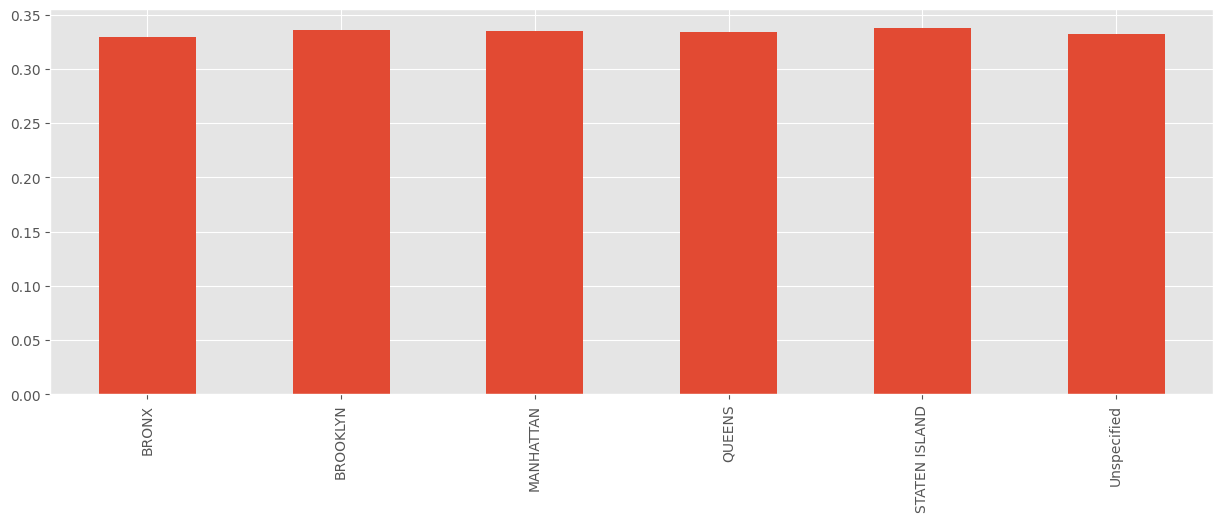

In [40]:
(noise_complaint_counts / complaint_counts.astype(float)).plot(kind='bar')

So Bronx really does complain more about noise than the other boroughs in our mock! Neat.

## Request real result

Now that we finished our analysis on the mock data, we can request this execution on the real data.

In [41]:
@sy.syft_function(input_policy=sy.ExactMatch(complaints=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(complaints):
    is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
    noise_complaints = complaints[is_noise]
    noise_complaint_counts = noise_complaints['Borough'].value_counts()
    complaint_counts = complaints['Borough'].value_counts()
    return noise_complaint_counts / complaint_counts.astype(float)

Request code execution

In [42]:
req = guest_domain_client.api.services.code.request_code_execution(get_counts)

In [43]:
submitted_code = guest_domain_client.code[0]

In [44]:
assert guest_domain_client.api.services.code.get_all()

Create and submit project

In [45]:
new_project = sy.Project(name="Pandas chapter 3",
                         description="Hi, I would like to plot the histogram of the noise complaint counts per area.")

In [46]:
new_project.add_request(obj=submitted_code, permission=sy.UserCodeStatus.EXECUTE)

In [47]:
guest_domain_client.submit_project(new_project)

<class 'syft.core.node.new.response.SyftSuccess'>: Project Submitted

# Data owner: execute function

In [49]:
from syft import Worker, MessageStatus
from syft.core.node.new.project import Project

## Get messages

In [55]:
domain_client = node.login(email="info@openmined.org", password="changethis")

In [56]:
messages = domain_client.api.services.messages.get_all_for_status(MessageStatus.UNDELIVERED)

In [57]:
messages

,type,id,subject,status,created_at,linked_obj
0,syft.core.node.new.messages.Message,0dd52c141e254a2ba818405752267fc3,Approval Request,MessageStatus.UNDELIVERED,2023-05-15 11:51:14,<<class 'syft.core.node.new.request.Request'>:...
1,syft.core.node.new.messages.Message,540496fdb35246a9a73c4329eaddfcd2,Project Approval,MessageStatus.UNDELIVERED,2023-05-15 11:51:14,<<class 'syft.core.node.new.project.Project'>:...


In [58]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [59]:
request = project_message.link.requests[0]
func = request.changes[0].link
op = func.output_policy_type

In [60]:
func

```python
class UserCode:
  id: str = d6ab2939944c4dcfb4bd7f743ebdac64
  node_uid: str = 7bca415d13ed1ec841f0d0aede098dbb
  user_verify_key: str = fc8f0bf64f61336feffd71a4de973e468996adb17bcf532108ef9e9dd832bcbc
  raw_code: str = "@sy.syft_function(input_policy=sy.ExactMatch(complaints=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(complaints):
    is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
    noise_complaints = complaints[is_noise]
    noise_complaint_counts = noise_complaints['Borough'].value_counts()
    complaint_counts = complaints['Borough'].value_counts()
    return noise_complaint_counts / complaint_counts.astype(float)
"
  input_policy_type: str = <class 'syft.core.node.new.policy.ExactMatch'>
  input_policy_init_kwargs: str = {NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): {'complaints': <UID: 1c6e3e5546194546aa5e797f1254bbc9>}}
  input_policy_state: str = b''
  output_policy_type: str = <class 'syft.core.node.new.policy.OutputPolicyExecuteOnce'>
  output_policy_init_kwargs: str = {}
  output_policy_state: str = b''
  parsed_code: str = "

def user_func_get_counts_fc8f0bf64f61336feffd71a4de973e468996adb17bcf532108ef9e9dd832bcbc_701f23755a69b9f3f6d34d6a02c53686edbd4a524ddd4cb2d4815c33b33a5b20(complaints):

    def get_counts(complaints):
        is_noise = (complaints['Complaint Type'] == 'Noise - Street/Sidewalk')
        noise_complaints = complaints[is_noise]
        noise_complaint_counts = noise_complaints['Borough'].value_counts()
        complaint_counts = complaints['Borough'].value_counts()
        return (noise_complaint_counts / complaint_counts.astype(float))
    result = get_counts(complaints=complaints)
    return result
"
  service_func_name: str = "get_counts"
  unique_func_name: str = "user_func_get_counts_fc8f0bf64f61336feffd71a4de973e468996adb17bcf532108ef9e9dd832bcbc_701f23755a69b9f3f6d34d6a02c53686edbd4a524ddd4cb2d4815c33b33a5b20"
  user_unique_func_name: str = "user_func_get_counts_fc8f0bf64f61336feffd71a4de973e468996adb17bcf532108ef9e9dd832bcbc"
  code_hash: str = "701f23755a69b9f3f6d34d6a02c53686edbd4a524ddd4cb2d4815c33b33a5b20"
  signature: str = (complaints)
  status: str = {NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): <UserCodeStatus.SUBMITTED: 'submitted'>}
  input_kwargs: str = ['complaints']
  enclave_metadata: str = None

```

In [61]:
get_counts_user_func = func.unsafe_function

In [62]:
real_data = domain_client.datasets[0].assets[0].data

In [63]:
real_result = get_counts_user_func(complaints=real_data)

In [64]:
real_result[:3]

BRONX        0.014833
BROOKLYN     0.013864
MANHATTAN    0.037755
Name: Borough, dtype: float64

In [65]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [66]:
asset = guest_client.datasets[0].assets[0]

In [67]:
guest_client.api.services.code[0].status

{NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): <UserCodeStatus.EXECUTE: 'execute'>}

<AxesSubplot: >

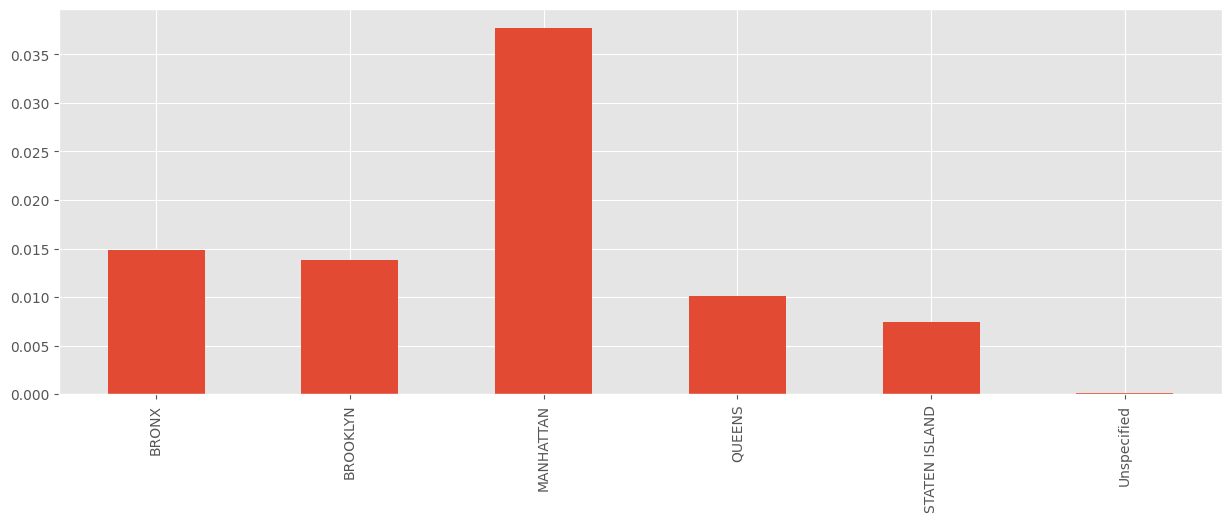

In [68]:
real_result = guest_client.api.services.code.get_counts(complaints=asset)
real_result.plot(kind="bar")